C:\Users\Sjard\AppData\Local\Temp\ipykernel_620044\2733521333.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0000e-02 7.3000e-01 1.7700e+00 2.8000e+00 3.7200e+00 4.7200e+00
 5.8100e+00 6.7800e+00 7.7400e+00 8.7900e+00 9.8200e+00 1.0750e+01
 1.1780e+01 1.2830e+01 1.3780e+01 1.4720e+01 1.5730e+01 1.6760e+01
 1.7810e+01 1.8720e+01 1.9740e+01 2.0780e+01 2.1810e+01 2.2760e+01
 2.3790e+01 2.4750e+01 2.5760e+01 2.6780e+01 2.7810e+01 2.8720e+01
 2.9750e+01 3.0800e+01 3.1730e+01 3.2760e+01 3.3780e+01 3.4820e+01
 3.5720e+01 3.6750e+01 3.7790e+01 3.8820e+01 3.9730e+01 4.0770e+01
 4.1800e+01 4.2730e+01 4.3750e+01 4.4770e+01 4.5810e+01 4.6760e+01
 4.7720e+01 4.8760e+01 4.9800e+01 5.0770e+01 5.1810e+01 5.2760e+01
 5.3790e+01 5.4820e+01 5.5730e+01 5.6760e+01 5.7790e+01 5.8810e+01
 5.9720e+01 6.0730e+01 6.1760e+01 6.2760e+01 6.3730e+01 6.4770e+01
 6.5800e+01 6.6800e+01 6.7720e+01 6.8760e+01 6.9780e+01 7.0820e+0

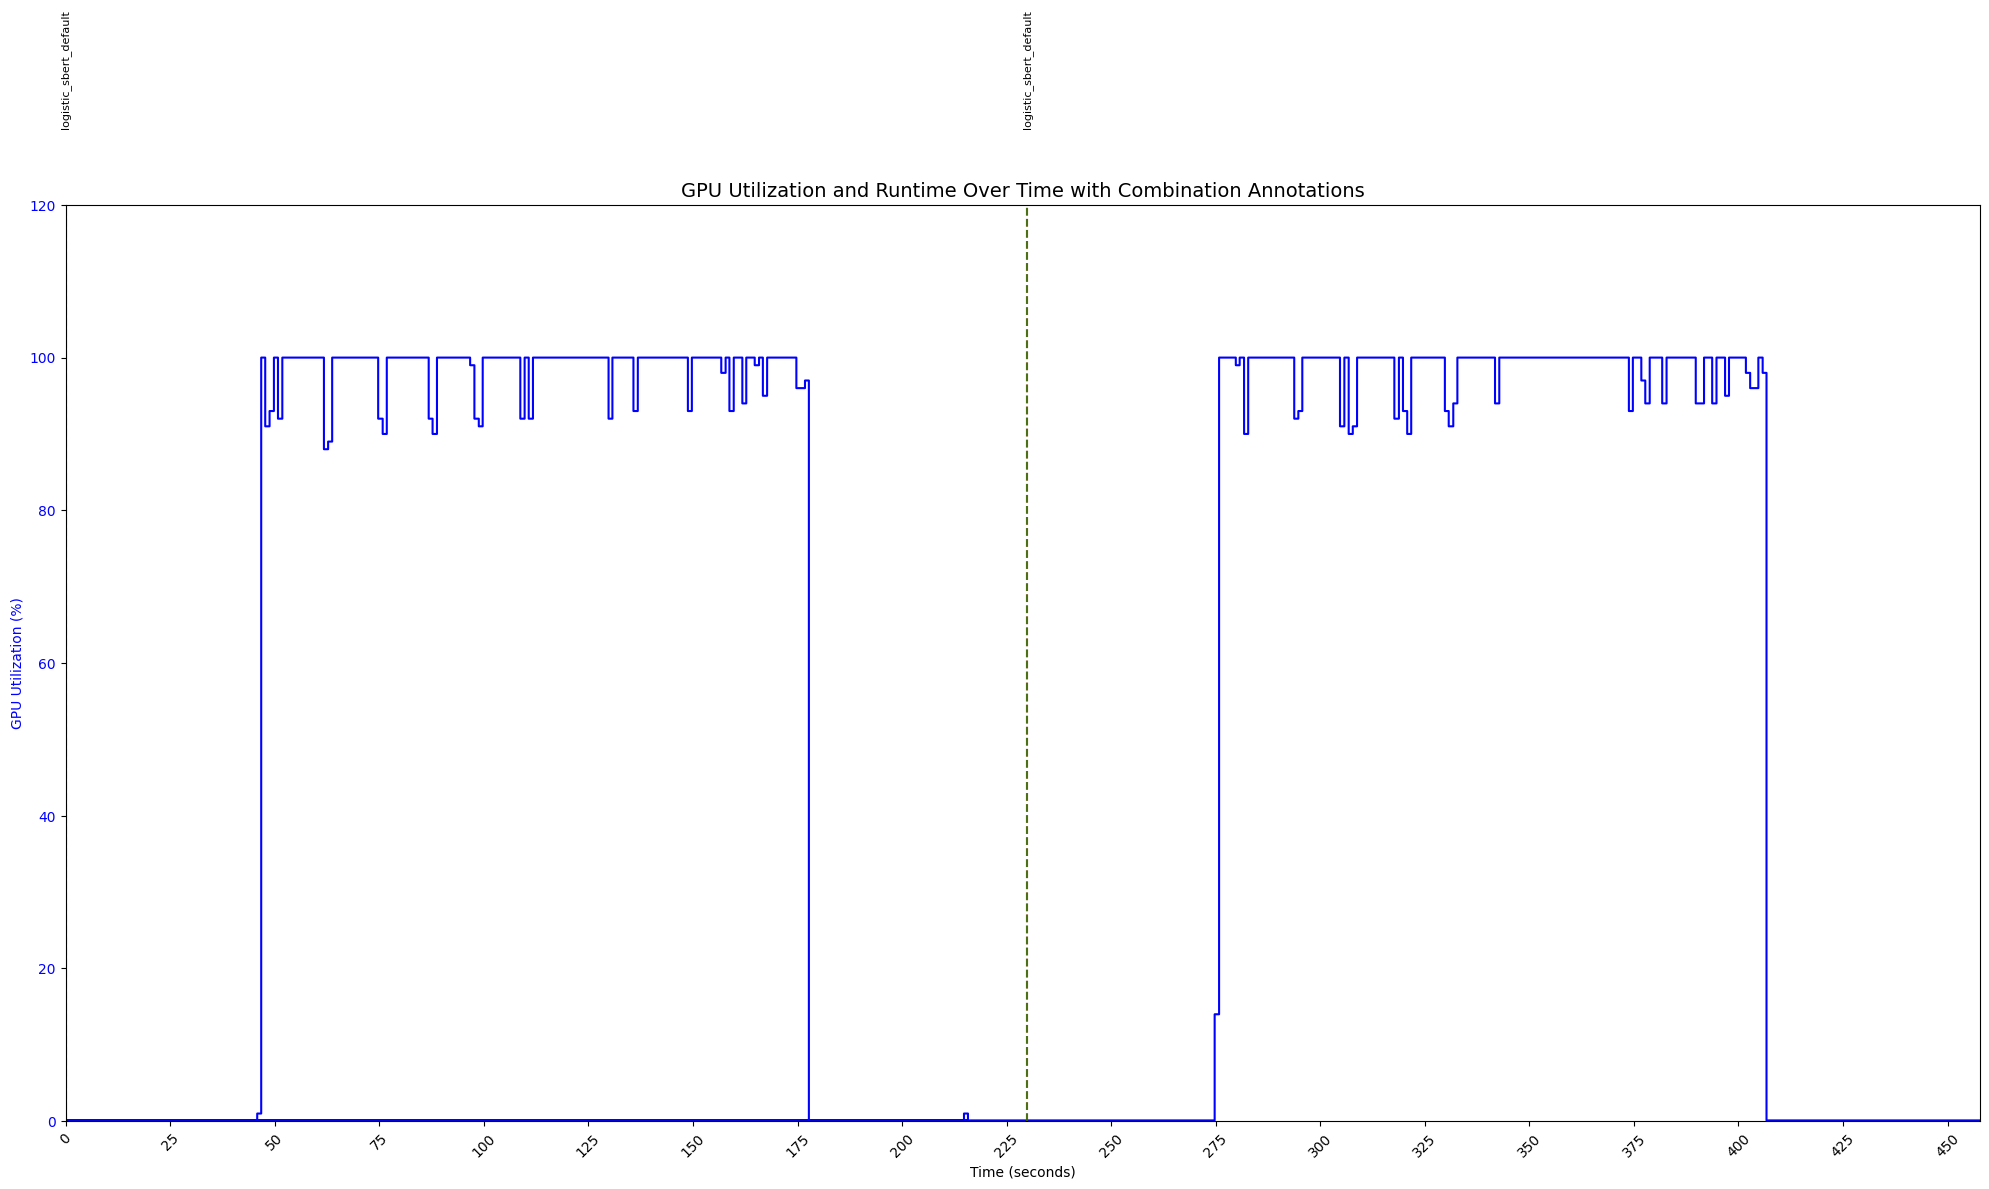

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Calculate GPU utilization seconds based on cumulative runtime
gpu_df['Cumulative_Start_Seconds'] = 0
gpu_df['Cumulative_End_Seconds'] = 0

current_time = 0
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['Start_Time'][mask] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['End_Time'][mask] - row['Start_Time']).dt.total_seconds()
    current_time = row['Cumulative_End_Seconds']

# Create the Graph
fig, ax1 = plt.subplots(figsize=(20, 12))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Cumulative_Start_Seconds'], row['Cumulative_End_Seconds']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

# Add a small offset to make low values visible
gpu_utils = [max(0.1, u) for u in gpu_utils]

ax1.plot(gpu_times, gpu_utils, color='b')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GPU Utilization (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Adjust y-axis limits
max_util = max(gpu_utils)
ax1.set_ylim(0, max_util * 1.2)

# Adjust x-axis limits
ax1.set_xlim(0, max(gpu_times))

# Annotate the plot with combinations and runtime
for i, row in comb_df.iterrows():
    ax1.axvline(x=row['Cumulative_Start_Seconds'], color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=row['Cumulative_End_Seconds'], color='r', linestyle='--', alpha=0.7)
    ax1.text(row['Cumulative_Start_Seconds'], max_util * 1.2 +  max_util * 0.1, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8, ha='center')

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

plt.xticks(rotation=45)

# Add title and legend
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Error parsing GPU log at line 16899: list index out of range
Error parsing combination log at line 0: list index out of range


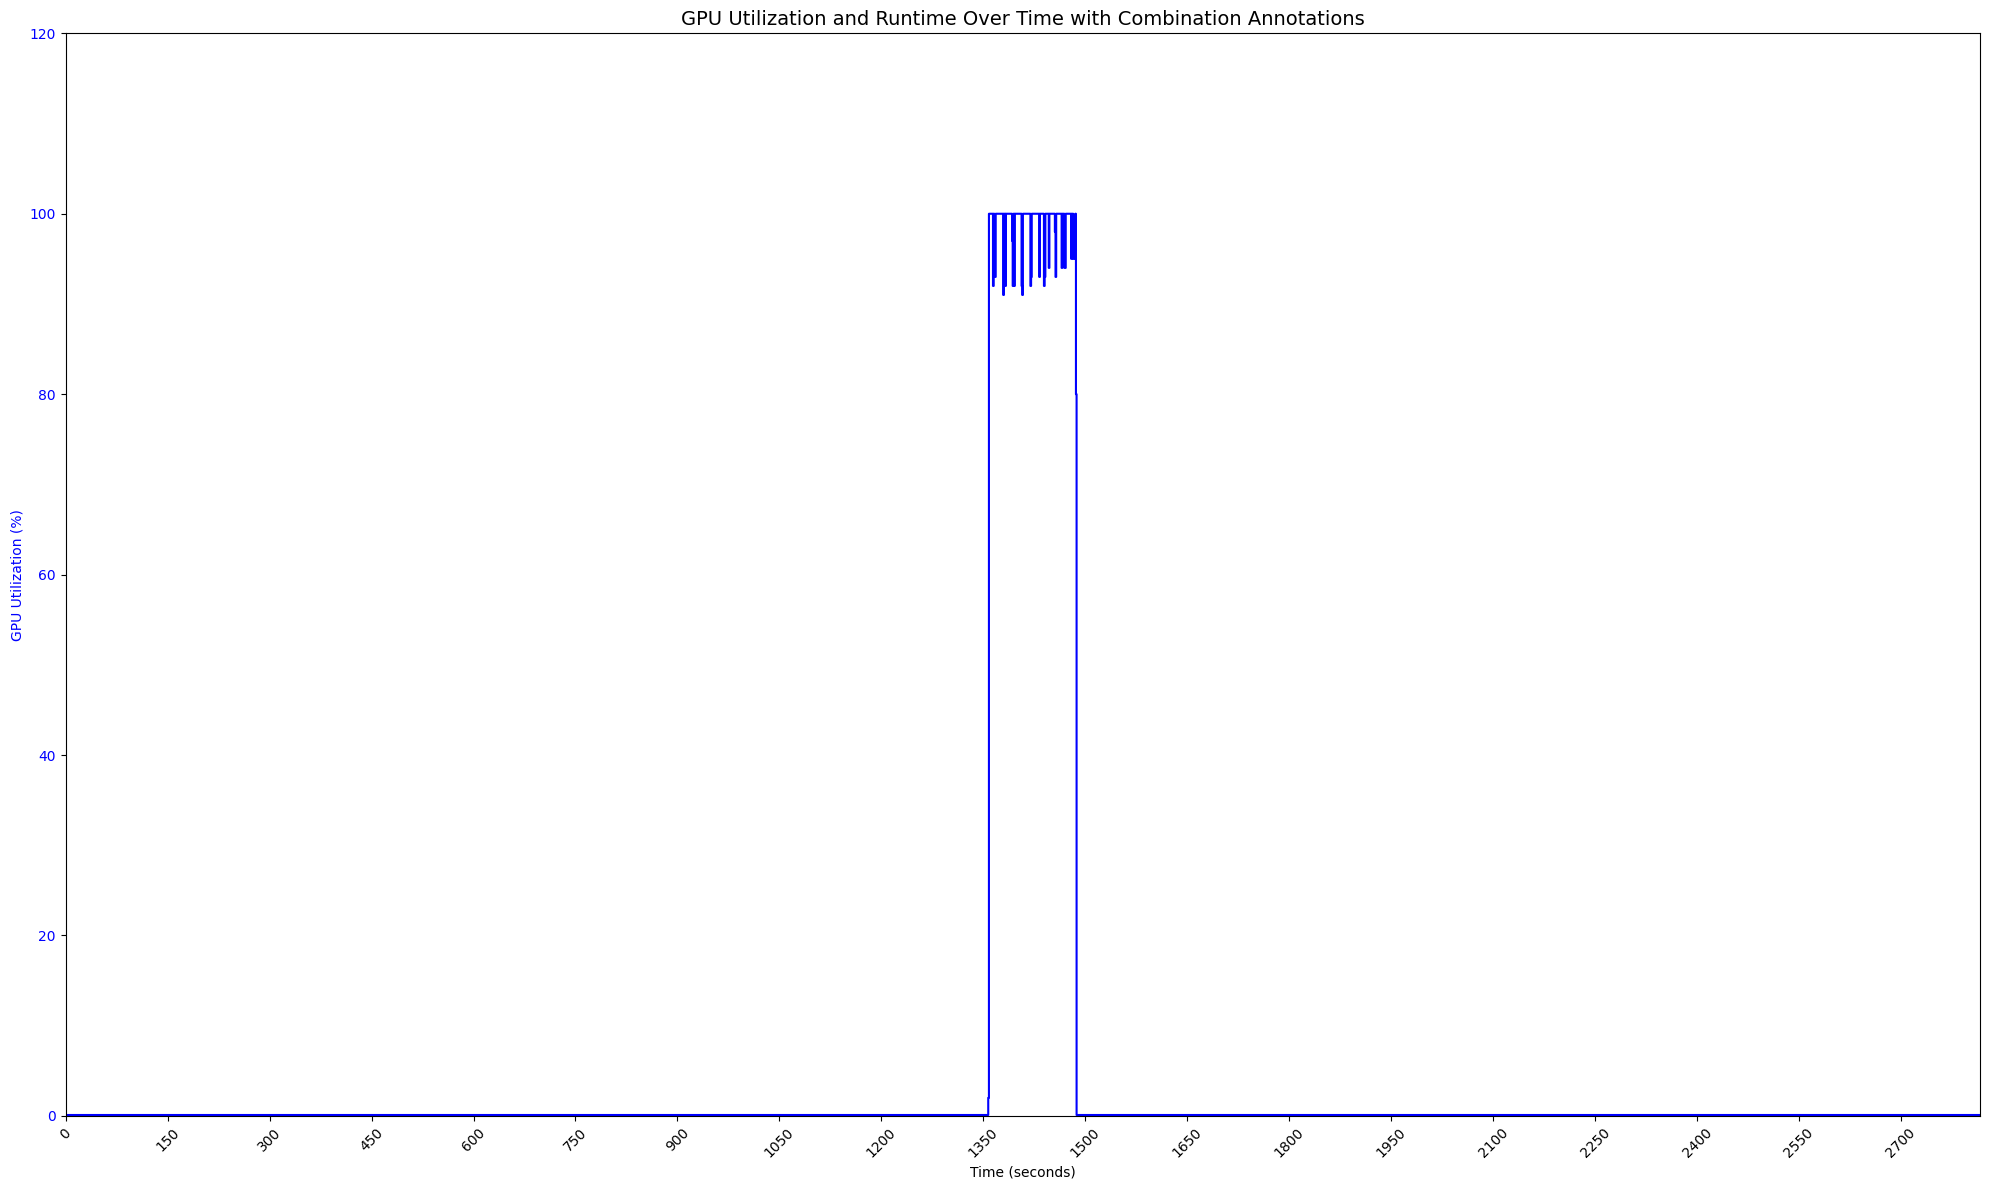

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Calculate the average GPU utilization for each combination
results = []
for _, comb_row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= comb_row['Start_Time']) & (gpu_df['End_Time'] <= comb_row['End_Time'])
    avg_gpu_util = gpu_df.loc[mask, 'GPU_Utilization'].mean()
    results.append((comb_row['Classifier'], comb_row['Feature_Extractor'], avg_gpu_util))

# Convert the results to a DataFrame
average_gpu_df = pd.DataFrame(results, columns=['Classifier', 'Feature_Extractor', 'Average_GPU_Utilization'])

# Save the average GPU utilization per combination to a CSV file
average_gpu_df.to_csv('average_gpu_utilization_per_combination.csv', index=False)

# Create the Graph
fig, ax1 = plt.subplots(figsize=(20, 12))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Start_Time'], row['End_Time']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

# Convert times to seconds from the start
start_time = gpu_df['Start_Time'].min()
gpu_times_in_seconds = [(time - start_time).total_seconds() for time in gpu_times]

# Add a small offset to make low values visible
gpu_utils = [max(0.1, u) for u in gpu_utils]

ax1.plot(gpu_times_in_seconds, gpu_utils, color='b')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GPU Utilization (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Adjust y-axis limits
max_util = max(gpu_utils)
ax1.set_ylim(0, max_util * 1.2)

# Adjust x-axis limits
ax1.set_xlim(0, max(gpu_times_in_seconds))

# Annotate the plot with combinations and runtime
for _, row in comb_df.iterrows():
    start_seconds = (row['Start_Time'] - start_time).total_seconds()
    end_seconds = (row['End_Time'] - start_time).total_seconds()
    ax1.axvline(x=start_seconds, color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=end_seconds, color='r', linestyle='--', alpha=0.7)
    ax1.text(start_seconds, max_util * 1.2 +  max_util * 0.1, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8, ha='center')

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

plt.xticks(rotation=45)

# Add title and legend
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


Results have been saved to 'classifier_results.csv'


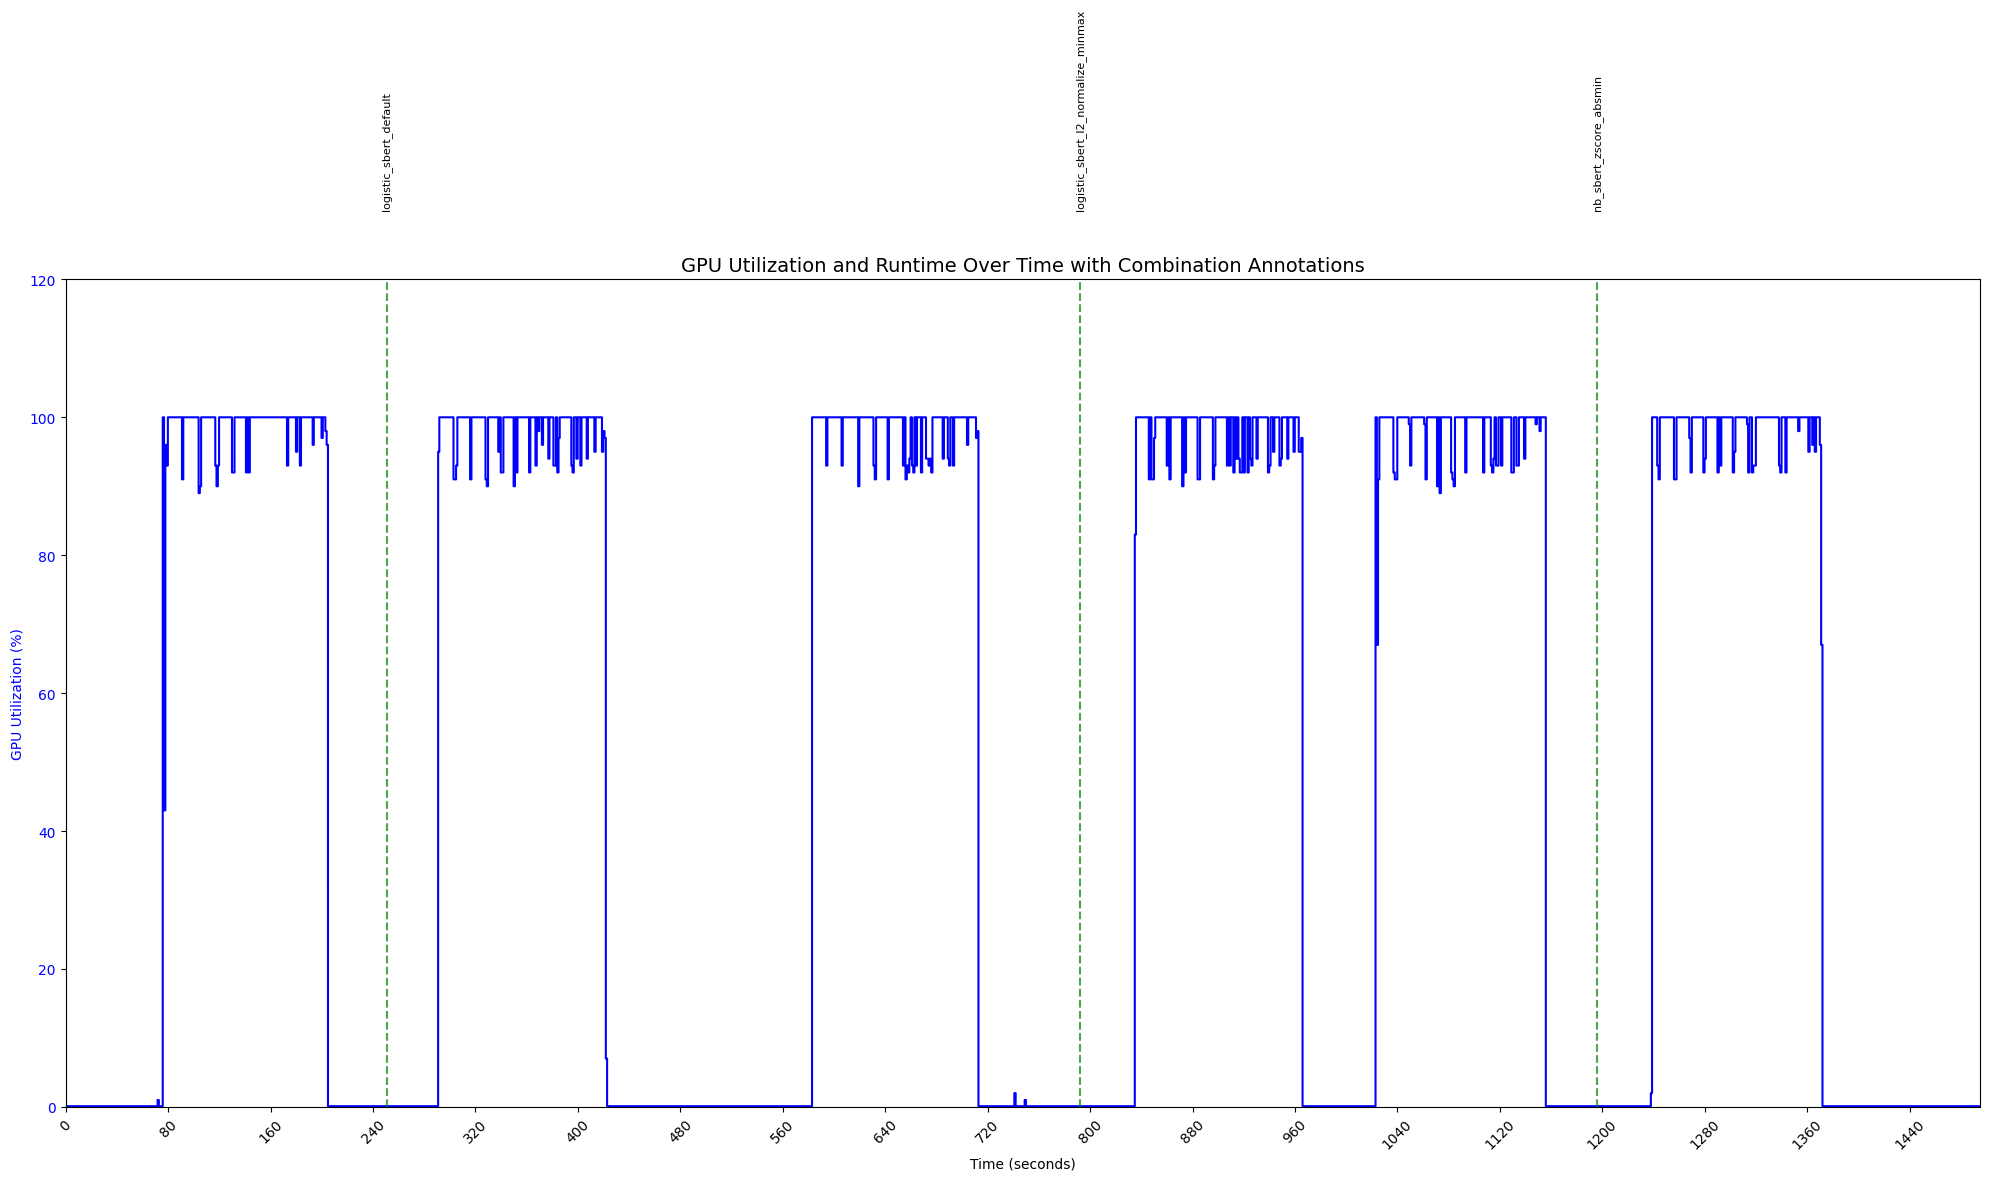

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
                i += 1
                continue
            elif line.startswith('utilization.gpu [%]'):
                if i + 2 < len(lines):
                    gpu_util = int(lines[i + 1].strip().replace('%', ''))
                    end_time_line = lines[i + 2].strip()
                    if end_time_line.startswith('Time end:'):
                        end_time = pd.to_datetime(end_time_line.split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                        if end_time < start_time:
                            end_time += pd.Timedelta(days=1)
                        gpu_data.append((start_time, end_time, gpu_util))
                        i += 2
                    else:
                        i += 1
                else:
                    i += 1
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                parts = lines[i].split('with')
                if len(parts) >= 2:
                    classifier = parts[0].split('classifier:')[1].strip()
                    feature_extractor = parts[1].split('feature extractor:')[1].strip()
                    
                    start_time = None
                    end_time = None
                    wss = None
                    
                    for j in range(i + 1, min(i + 10, len(lines))):
                        if 'Start Time:' in lines[j]:
                            start_time = pd.to_datetime(lines[j].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                        elif 'End Time:' in lines[j]:
                            end_time = pd.to_datetime(lines[j].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                        elif 'wss_95' in lines[j]:
                            wss = float(lines[j].split(':')[1].strip())
                    
                    if start_time and end_time:
                        if end_time < start_time:
                            end_time += pd.Timedelta(days=1)
                        runtime = (end_time - start_time).total_seconds()
                        comb_data.append((classifier, feature_extractor, start_time, end_time, runtime, wss))
                    
                    i = j + 1
                else:
                    i += 1
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds', 'WSS'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Calculate the average GPU utilization for each combination
results = []
for _, comb_row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= comb_row['Start_Time']) & (gpu_df['End_Time'] <= comb_row['End_Time'])
    avg_gpu_util = gpu_df.loc[mask, 'GPU_Utilization'].mean()
    results.append((
        comb_row['Classifier'],
        comb_row['Feature_Extractor'],
        comb_row['WSS'],
        comb_row['Runtime_Seconds'],
        avg_gpu_util
    ))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Classifier', 'Feature_Extractor', 'WSS', 'Runtime', 'GPU_Utilization'])

# Save the results to a CSV file
results_df.to_csv('classifier_results.csv', index=False)

print("Results have been saved to 'classifier_results.csv'")

# Create the Graph
fig, ax1 = plt.subplots(figsize=(20, 12))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Start_Time'], row['End_Time']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

# Convert times to seconds from the start
start_time = gpu_df['Start_Time'].min()
gpu_times_in_seconds = [(time - start_time).total_seconds() for time in gpu_times]

# Add a small offset to make low values visible
gpu_utils = [max(0.1, u) for u in gpu_utils]

ax1.plot(gpu_times_in_seconds, gpu_utils, color='b')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GPU Utilization (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Adjust y-axis limits
max_util = max(gpu_utils)
ax1.set_ylim(0, max_util * 1.2)

# Adjust x-axis limits
ax1.set_xlim(0, max(gpu_times_in_seconds))

# Annotate the plot with combinations and runtime
for _, row in comb_df.iterrows():
    start_seconds = (row['Start_Time'] - start_time).total_seconds()
    end_seconds = (row['End_Time'] - start_time).total_seconds()
    ax1.axvline(x=start_seconds, color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=end_seconds, color='r', linestyle='--', alpha=0.7)
    ax1.text(start_seconds, max_util * 1.2 +  max_util * 0.1, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8, ha='center')

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

plt.xticks(rotation=45)

# Add title and legend
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
